In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# ======= Load dữ liệu từ MNIST tùy chỉnh =======
def load_mnist_from_folder(folder, label_csv):
    df = pd.read_csv(label_csv)
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row["filename"])
        img = Image.open(img_path).convert("L")
        img = np.array(img).reshape(28, 28, 1).astype("float32") / 255.0
        images.append(img)
        labels.append(int(row["label"]))
    return np.array(images), np.array(labels)

In [3]:
# ======= Load và kết hợp MNIST + A-Z =======
x_mnist_train, y_mnist_train = load_mnist_from_folder(
    r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\train",
    r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\train_labels.csv"
)

x_mnist_test, y_mnist_test = load_mnist_from_folder(
    r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\test",
    r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\test_labels.csv"
)

x_mnist = np.concatenate([x_mnist_train, x_mnist_test], axis=0)
y_mnist = np.concatenate([y_mnist_train, y_mnist_test], axis=0)

df_az = pd.read_csv(r'F:\DAKHMT\CLone\Hand-Written\datas\A_Z Handwritten Data.csv')
X_az = df_az.drop("0", axis=1).values.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_az = df_az["0"].values.astype(np.int32) + 10

X = np.concatenate([x_mnist, X_az], axis=0)
y = np.concatenate([y_mnist, y_az], axis=0)

num_classes = 36
y_cat = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.1, random_state=42)

In [4]:
# ======= Tạo mô hình Deep CNN =======
def create_deep_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(36, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# ======= Huấn luyện mô hình =======
model = create_deep_cnn()
checkpoint = ModelCheckpoint("best_deepcnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    verbose=2
)
# ======= Đánh giá mô hình =======
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n[INFO] Final Test Accuracy: {acc*100:.2f}%")
print(f"[INFO] Final Test Loss: {loss:.4f}")

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.96296, saving model to best_deepcnn_model.h5
3111/3111 - 806s - loss: 0.3751 - accuracy: 0.8957 - val_loss: 0.1379 - val_accuracy: 0.9630 - 806s/epoch - 259ms/step
Epoch 2/20


f:\DAKHMT\PKHMT_F\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.96296 to 0.98095, saving model to best_deepcnn_model.h5
3111/3111 - 773s - loss: 0.1418 - accuracy: 0.9605 - val_loss: 0.0689 - val_accuracy: 0.9809 - 773s/epoch - 248ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.98095 to 0.98253, saving model to best_deepcnn_model.h5
3111/3111 - 1381s - loss: 0.1117 - accuracy: 0.9689 - val_loss: 0.0607 - val_accuracy: 0.9825 - 1381s/epoch - 444ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.98253 to 0.98465, saving model to best_deepcnn_model.h5
3111/3111 - 899s - loss: 0.0938 - accuracy: 0.9742 - val_loss: 0.0525 - val_accuracy: 0.9847 - 899s/epoch - 289ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.98465 to 0.98773, saving model to best_deepcnn_model.h5
3111/3111 - 840s - loss: 0.0839 - accuracy: 0.9768 - val_loss: 0.0444 - val_accuracy: 0.9877 - 840s/epoch - 270ms/step
Epoch 6/20

Epoch 6: val_accuracy improved from 0.98773 to 0.98809, saving model to best_deepcnn_model.h5
311

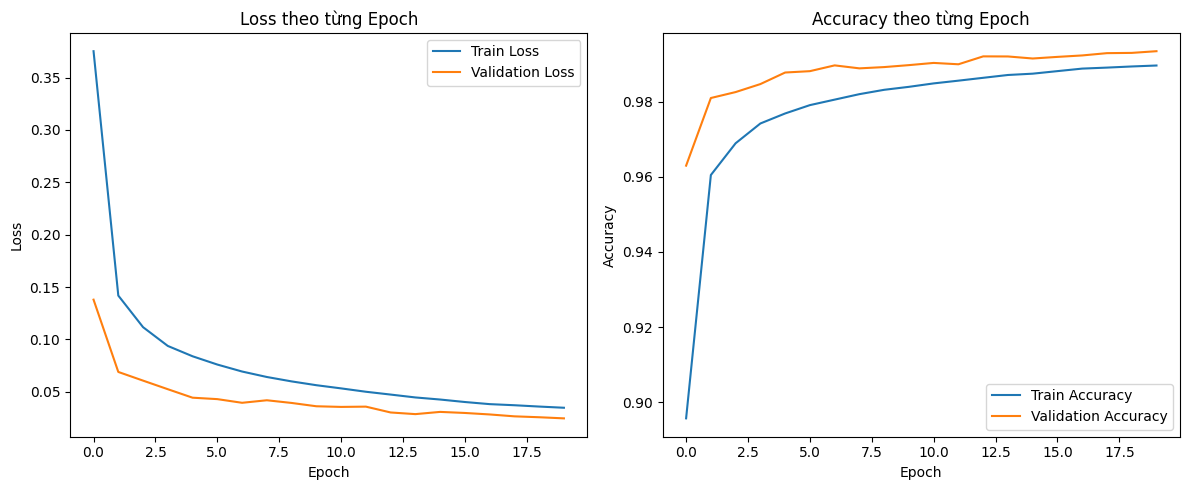

In [7]:
# ======= Vẽ biểu đồ loss & accuracy =======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss theo từng Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy theo từng Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()